In [13]:
!pip install -q grad-cam

In [3]:
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix, classification_report
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import torch
import numpy as np
import random
import warnings
import shutil
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

In [4]:
# For reproducibility
seed = 27
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


In [5]:
dataset_path = 'D:/6th Sem Projects/CV Project/archive/chest_xray/'

train_path = f'{dataset_path}/train/'
val_path = f'{dataset_path}/val/'
test_path = f'{dataset_path}/test/'

In [6]:
train_path

'D:/6th Sem Projects/CV Project/archive/chest_xray//train/'

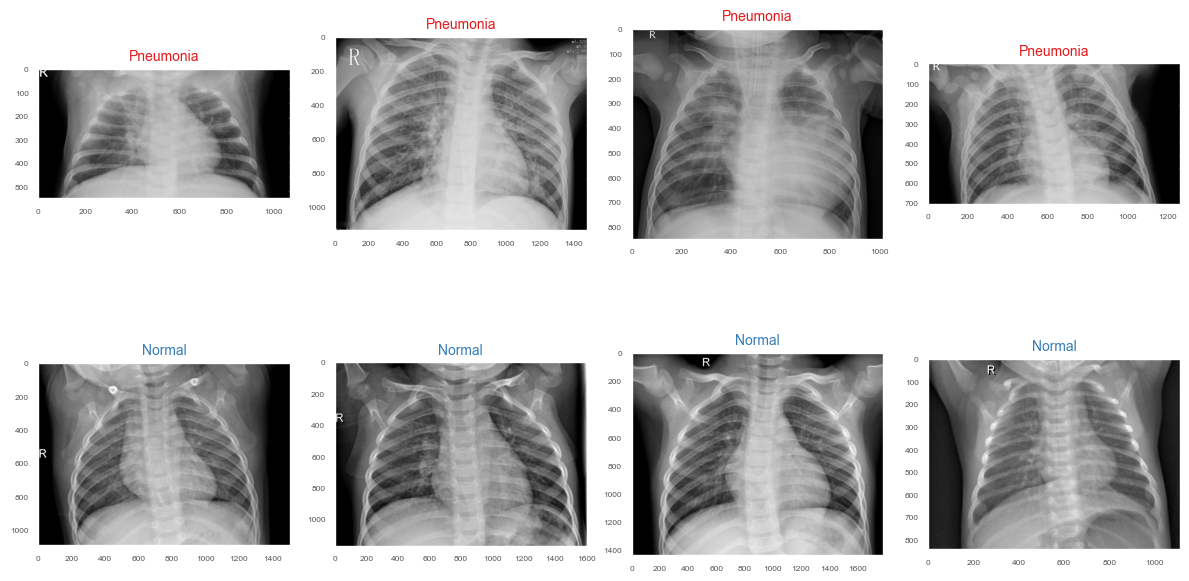

In [7]:

random_pneumonia_samples = random.sample(os.listdir(f'{train_path}/PNEUMONIA'), 4)
random_non_pneumonia_samples = random.sample(os.listdir(f'{train_path}/NORMAL'), 4)

plt.rcParams['axes.grid'] = False
colors = sns.color_palette('Set1', 2)
fig, ax = plt.subplots(2, 4, figsize=(12, 7))
ax = ax.flatten()

for i in range(4):
    filename = random_pneumonia_samples[i]
    image = Image.open(f'{train_path}/PNEUMONIA/{filename}')
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title('Pneumonia', color=colors[0], fontsize=10)
    ax[i].tick_params(axis='both', which='major', labelsize=6)

for i in range(4, 8):
    filename = random_non_pneumonia_samples[i-5]
    image = Image.open(f'{train_path}/NORMAL/{filename}')
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title('Normal', color=colors[1], fontsize=10)
    ax[i].tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.show()

In [8]:

def plot_label_distribution(train_path: str, val_path: str, test_path: str) -> None:
    plt.rcParams['axes.grid'] = True
    train_counts = [len(os.listdir(f'{train_path}/{cls}')) for cls in ['NORMAL', 'PNEUMONIA']]
    val_counts = [len(os.listdir(f'{val_path}/{cls}')) for cls in ['NORMAL', 'PNEUMONIA']]
    test_counts = [len(os.listdir(f'{test_path}/{cls}')) for cls in ['NORMAL', 'PNEUMONIA']]
    total_counts = [sum(x) for x in zip(train_counts, val_counts, test_counts)]

    total_train = sum(train_counts)
    total_val = sum(val_counts)
    total_test = sum(test_counts)
    total_images = sum(total_counts)

    fig, ax = plt.subplots(1, 4, figsize=(14, 5))
    bars0 = ax[0].bar(['Normal', 'Pneumonia'], train_counts, color=colors)
    ax[0].set_title('Train')
    ax[0].set_ylabel('Number of images')
    bars1 = ax[1].bar(['Normal', 'Pneumonia'], val_counts, color=colors)
    ax[1].set_title('Validation')
    bars2 = ax[2].bar(['Normal', 'Pneumonia'], test_counts, color=colors)
    ax[2].set_title('Test')
    bars3 = ax[3].bar(['Normal', 'Pneumonia'], total_counts, color=colors)
    ax[3].set_title('Total')

    def add_labels(bars, ax, total):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height,
                    f'{height} ({height / total:.1%})',
                    ha='center', va='bottom')

    add_labels(bars0, ax[0], total_train)
    add_labels(bars1, ax[1], total_val)
    add_labels(bars2, ax[2], total_test)
    add_labels(bars3, ax[3], total_images)

    plt.tight_layout()
    plt.show()

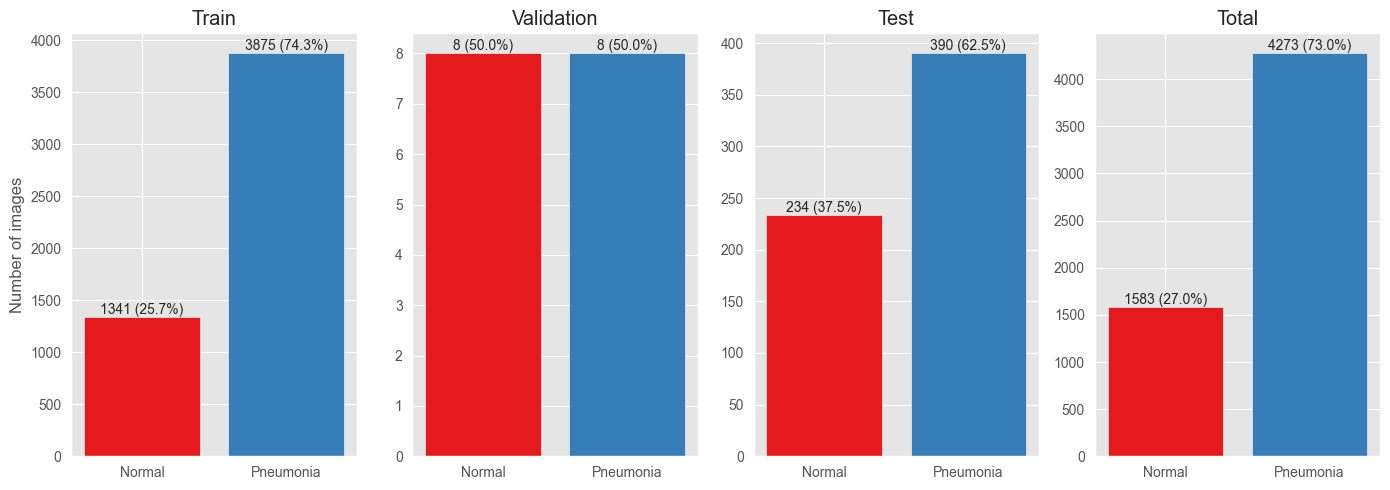

In [9]:
plot_label_distribution(train_path, val_path, test_path)

In [8]:
new_dataset_path = 'D:/6th Sem Projects/CV Project/archive_new/chest_xray'

new_train_path = f'{new_dataset_path}/train/'
new_val_path = f'{new_dataset_path}/val/'
new_test_path = f'{new_dataset_path}/test/'

if not os.path.exists(new_dataset_path):
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(f'{new_dataset_path}/{split}/{cls}', exist_ok=True)
            
    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = f'{dataset_path}/{split}/{cls}'
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])
        
        random.shuffle(all_files)
        
        train_files = all_files[:int(len(all_files)*0.8)]
        val_files = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)]
        test_files = all_files[int(len(all_files)*0.9):]
        
        for file, source_folder in train_files:
            dest = f'{new_dataset_path}/train/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)
        
        for file, source_folder in val_files:
            dest = f'{new_dataset_path}/val/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)
        
        for file, source_folder in test_files:
            dest = f'{new_dataset_path}/test/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)  

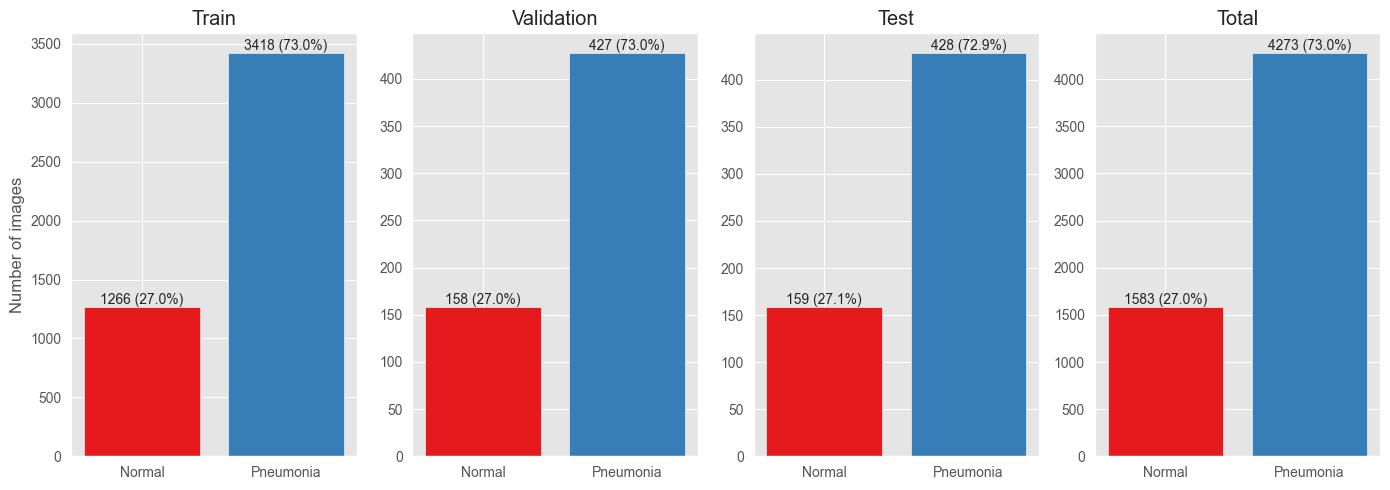

In [11]:
plot_label_distribution(new_train_path, new_val_path, new_test_path)

In [12]:
new_test_path

'D:/6th Sem Projects/CV Project/archive_new/chest_xray/test/'

In [13]:
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 16
NUM_WORKERS = 4
DATA_TYPES = ['train', 'val', 'test']

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(new_dataset_path, x), data_transforms[x]) for x in DATA_TYPES}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in DATA_TYPES}
dataset_sizes = {x: len(image_datasets[x]) for x in DATA_TYPES}
class_names = image_datasets['train'].classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt


class Trainer:
    def __init__(
        self,
        device: str,
        model: torch.nn.Module,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        test_dataloader: DataLoader,
        checkpoint_path: str,
        pneumonia_samples: str
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_accuracy = 0.0
        self.best_model_path = None
        self.pneumonia_samples = pneumonia_samples

    def save_cam_samples(self, model: torch.nn.Module, epoch_nr: int) -> None:
        targets = [1, 1, 1, 1, 1]

        target_layer = [model.layer4]  # Choosing the layer for Grad-CAM, you can adjust as needed
        cam = GradCAM(model=model, target_layers=target_layer)

        plt.rcParams['axes.grid'] = False

        for i, (image_path, target) in enumerate(zip(self.pneumonia_samples, targets)):
            image = Image.open(image_path).convert('RGB')
            image_tensor = transforms.ToTensor()(image).unsqueeze(0)

            image = transforms.ToTensor()(image)
            image = image.numpy().transpose((1, 2, 0))
            image = np.clip(image, 0, 1)

            targets = [ClassifierOutputTarget(target)]
            grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]

            visualization = show_cam_on_image(np.array(image_tensor[0].permute(1, 2, 0)), grayscale_cam, use_rgb=True)

            filename = image_path.split('/')[-1].split('.')[0]
            filetype = image_path.split('/')[-1].split('.')[1]
            plt.imshow(visualization)
            plt.axis('off')
            plt.savefig(f'samples/{filename}-cam-epoch-{epoch_nr}.{filetype}', bbox_inches='tight', pad_inches=0)
            plt.close()

    def train(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0

        if current_epoch_nr == 1:
            self.save_cam_samples(self.model, 0)

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device), y.to(self.device)

            self.optimizer.zero_grad()

            y_hat = self.model(x)
            _, preds = torch.max(y_hat, 1)
            loss = self.criterion(y_hat, y)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            n_corrects += torch.sum(preds == y.data).data.item()
            total += y.size(0)

            loop.set_description(f'Epoch {current_epoch_nr}')
            loop.set_postfix(train_acc=round(n_corrects / total, 5),
                             train_loss=round(running_loss / total, 5))

        self.scheduler.step()

        train_accuracy = n_corrects / total
        train_loss = running_loss / num_batches

        return train_accuracy, train_loss

    def evaluate(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                self.optimizer.zero_grad()

                y_hat = self.model(x)
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)


                loop.set_description(f'Epoch {current_epoch_nr}')
                loop.set_postfix(val_acc=round(n_corrects / total, 5),
                                 val_loss=round(running_loss / total, 5))

        val_accuracy = n_corrects / total
        val_loss = running_loss / num_batches

        self.save_cam_samples(self.model, current_epoch_nr)
        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            checkpoint_name = f'epoch_{current_epoch_nr}_acc_{round(val_accuracy, 2)}.pth'
            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(self.checkpoint_path, checkpoint_name)

        return val_accuracy, val_loss

    def test(self) -> Tuple[float, float, list, list, torch.nn.Module]:
        self.model.eval()

        num_batches = len(self.test_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0

        targets = []
        predictions = []

        with torch.no_grad():
            loop = tqdm(self.test_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                y_hat = self.model(x)
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)

                targets.extend(y.cpu().numpy())
                predictions.extend(preds.cpu().numpy())

                loop.set_description('Testing')
                loop.set_postfix(test_acc=round(n_corrects / total, 5),
                                 test_loss=round(running_loss / total, 5))

        test_accuracy = n_corrects / total
        test_loss = running_loss / num_batches

        print('\nTest Accuracy: ', test_accuracy)
        print('Test Loss: ', test_loss)

        self.model.load_state_dict(torch.load(self.best_model_path))

        return test_accuracy, test_loss, targets, predictions, self.model

# Sample paths for visualization with Grad-CAM
pneumonia_samples = [
    new_test_path + 'PNEUMONIA/person128_bacteria_605.jpeg',
    new_test_path + 'PNEUMONIA/person111_virus_209.jpeg',
    new_test_path + 'PNEUMONIA/person266_bacteria_1249.jpeg',
    new_test_path + 'PNEUMONIA/person297_bacteria_1400.jpeg',
    new_test_path + 'PNEUMONIA/person325_bacteria_1501.jpeg'
]
os.makedirs('samples', exist_ok=True)
for sample in pneumonia_samples:
    img = Image.open(sample)
    img.save('samples/' + sample.split('/')[-1])



In [22]:
# Define your ResNet model
model = models.resnet50(pretrained=True)  # Using pre-trained ResNet-50
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Modify the output layer for your task
model = model.to(device)

# Define your criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



In [16]:
max_epochs = 10

# Define your data loaders
train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']
test_dataloader = dataloaders['test']

# Define your checkpoint path
checkpoint_path = 'checkpoint-resnet'
try:
    os.mkdir(checkpoint_path)
except FileExistsError:
    pass

# Create trainer instance
trainer = Trainer(
    device=device,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    checkpoint_path=checkpoint_path,
    pneumonia_samples=pneumonia_samples
)

# Training loop
histories = []
max_epochs = 10
for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = trainer.train(current_epoch_nr=epoch)
    val_acc, val_loss = trainer.evaluate(current_epoch_nr=epoch)

    histories.append({
        'epoch': epoch,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

# Testing
test_acc, test_loss, targets, predictions, best_model = trainer.test()
torch.save(trainer.model.state_dict(), os.path.join('checkpoint-resnet', 'trained_model.pth'))

Testing: 100%|██████████| 37/37 [00:06<00:00,  5.33it/s, test_acc=0.983, test_loss=0.0658]



Test Accuracy:  0.9829642248722317
Test Loss:  1.0441571311597284


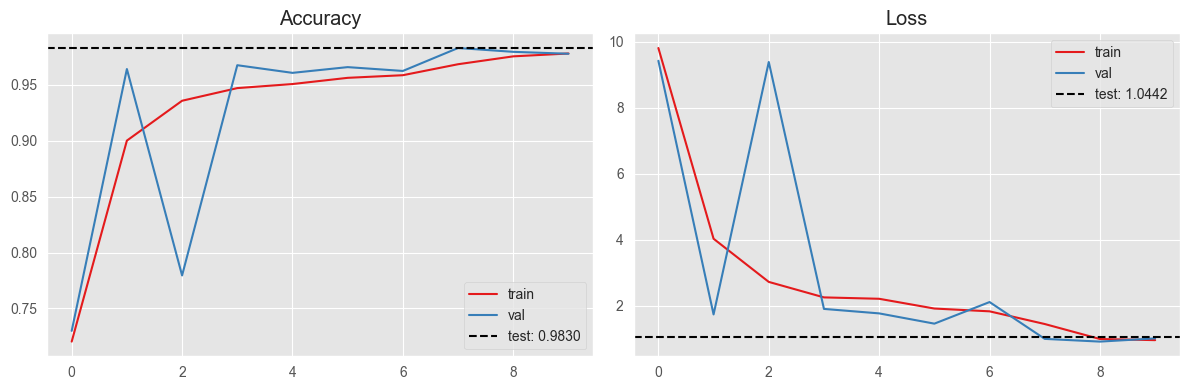

In [36]:
train_accs = [x['train_acc'] for x in histories]
train_losses = [x['train_loss'] for x in histories]
val_accs = [x['val_acc'] for x in histories]
val_losses = [x['val_loss'] for x in histories]

plt.rcParams['axes.grid'] = True
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='train', color=colors[0])
plt.plot(val_accs, label='val', color=colors[1])
plt.axhline(y=test_acc, color='black', linestyle='--', label=f'test: {test_acc:.4f}')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='train', color=colors[0])
plt.plot(val_losses, label='val', color=colors[1])
plt.axhline(y=test_loss, color='black', linestyle='--', label=f'test: {test_loss:.4f}')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [1]:
import plotly.graph_objects as go

train_accs = [x['train_acc'] for x in histories]
train_losses = [x['train_loss'] for x in histories]
val_accs = [x['val_acc'] for x in histories]
val_losses = [x['val_loss'] for x in histories]

fig = go.Figure()

# Accuracy subplot
fig.add_trace(go.Scatter(x=list(range(len(train_accs))), y=train_accs, mode='lines', name='Train', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=list(range(len(val_accs))), y=val_accs, mode='lines', name='Validation', line=dict(color='red')))
fig.add_trace(go.Scatter(x=[0, len(train_accs)], y=[test_acc, test_acc], mode='lines', name=f'Test: {test_acc:.4f}', line=dict(color='black', dash='dash')))
fig.update_xaxes(title_text="Epoch")
fig.update_yaxes(title_text="Accuracy")
fig.update_layout(title_text="Accuracy Plot with ResNet and GradCAM")

# Loss subplot
fig.add_trace(go.Scatter(x=list(range(len(train_losses))), y=train_losses, mode='lines', name='Train', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=list(range(len(val_losses))), y=val_losses, mode='lines', name='Validation', line=dict(color='red')))
fig.add_trace(go.Scatter(x=[0, len(train_losses)], y=[test_loss, test_loss], mode='lines', name=f'Test: {test_loss:.4f}', line=dict(color='black', dash='dash')))
fig.update_xaxes(title_text="Epoch")
fig.update_yaxes(title_text="Loss")
fig.update_layout(title_text="Loss Plot with ResNet with GradCAM")

fig.write_html("plot_with_resnet_and_gradcam.html")  # Save the plot as an HTML file

# Open the HTML file in your default web browser
import webbrowser
webbrowser.open("plot_with_resnet_and_gradcam.html")


NameError: name 'histories' is not defined

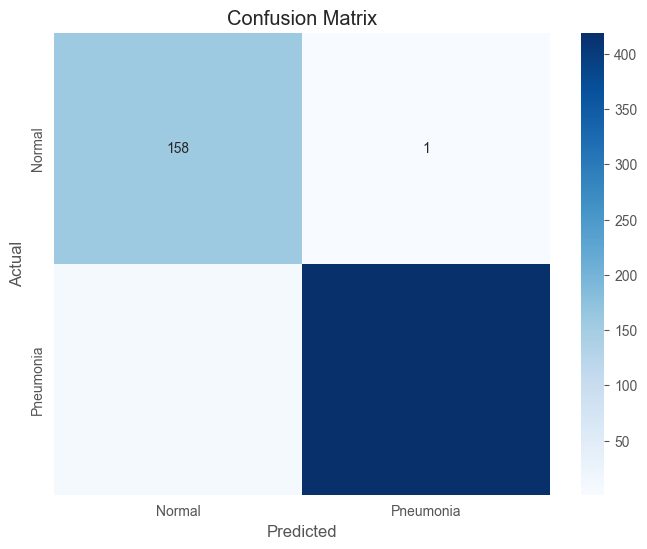

In [18]:
cm = confusion_matrix(targets, predictions)

plt.rcParams['axes.grid'] = False
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
print(classification_report(targets, predictions, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.96      0.97      0.97       159
   Pneumonia       0.99      0.98      0.99       428

    accuracy                           0.98       587
   macro avg       0.97      0.98      0.98       587
weighted avg       0.98      0.98      0.98       587


In [29]:
import torch
import torchvision.models as models
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def plot_cam(model: models.resnet.ResNet, image_paths: list, targets: list) -> None:
    model = model.eval()
    
    # Select an appropriate target layer from ResNet
    target_layer = [model.layer4[1]]  # Example: last layer of ResNet50
    
    cam = GradCAM(model=model, target_layers=target_layer)

    plt.rcParams['axes.grid'] = False
    fig, axs = plt.subplots(2, len(image_paths), figsize=(14, 7))

    for i, (image_path, target) in enumerate(zip(image_paths, targets)):
        image = Image.open(image_path).convert('RGB')
        image = transforms.ToTensor()(image)
        
        image_tensor = image.unsqueeze(0)
        
        image = image.numpy().transpose((1, 2, 0))
        image = np.clip(image, 0, 1)
        
        target_list = [target]  # Ensure target is in the list format
        grayscale_cam = cam(input_tensor=image_tensor, targets=target_list)
        grayscale_cam = grayscale_cam[0, :]

        visualization = visualize_cam(mask=grayscale_cam, img=image)

        axs[1, i].imshow(image)
        axs[1, i].set_title('Original')
        axs[1, i].tick_params(axis='both', which='major', labelsize=6)

        axs[0, i].imshow(visualization)
        axs[0, i].set_title('Grad-CAM')
        axs[0, i].tick_params(axis='both', which='major', labelsize=6)

    plt.tight_layout()
    plt.show()


In [4]:
def plot_cam(model: models.resnet.ResNet, image_paths: list, targets: list) -> None:
    model = model.eval()
    
    target_layer = [model.layer4]
    cam = GradCAM(model=model, target_layers=target_layer)

    plt.rcParams['axes.grid'] = False
    fig, axs = plt.subplots(2, 4, figsize=(14, 7))

    for i, (image_path, target) in enumerate(zip(image_paths, targets)):
        image = Image.open(image_path).convert('RGB')
        image = transforms.ToTensor()(image)
        
        image_tensor = image.unsqueeze(0)
        
        image = image.numpy().transpose((1, 2, 0))
        image = np.clip(image, 0, 1)
        
        targets = [ClassifierOutputTarget(target)]
        grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        visualization = show_cam_on_image(np.array(image_tensor[0].permute(1, 2, 0)), grayscale_cam, use_rgb=True)

        axs[1, i].imshow(image)
        axs[1, i].set_title('Original')
        axs[1, i].tick_params(axis='both', which='major', labelsize=6)

        axs[0, i].imshow(visualization)
        axs[0, i].set_title('Grad-CAM')
        axs[0, i].tick_params(axis='both', which='major', labelsize=6)

    plt.tight_layout()
    plt.show()

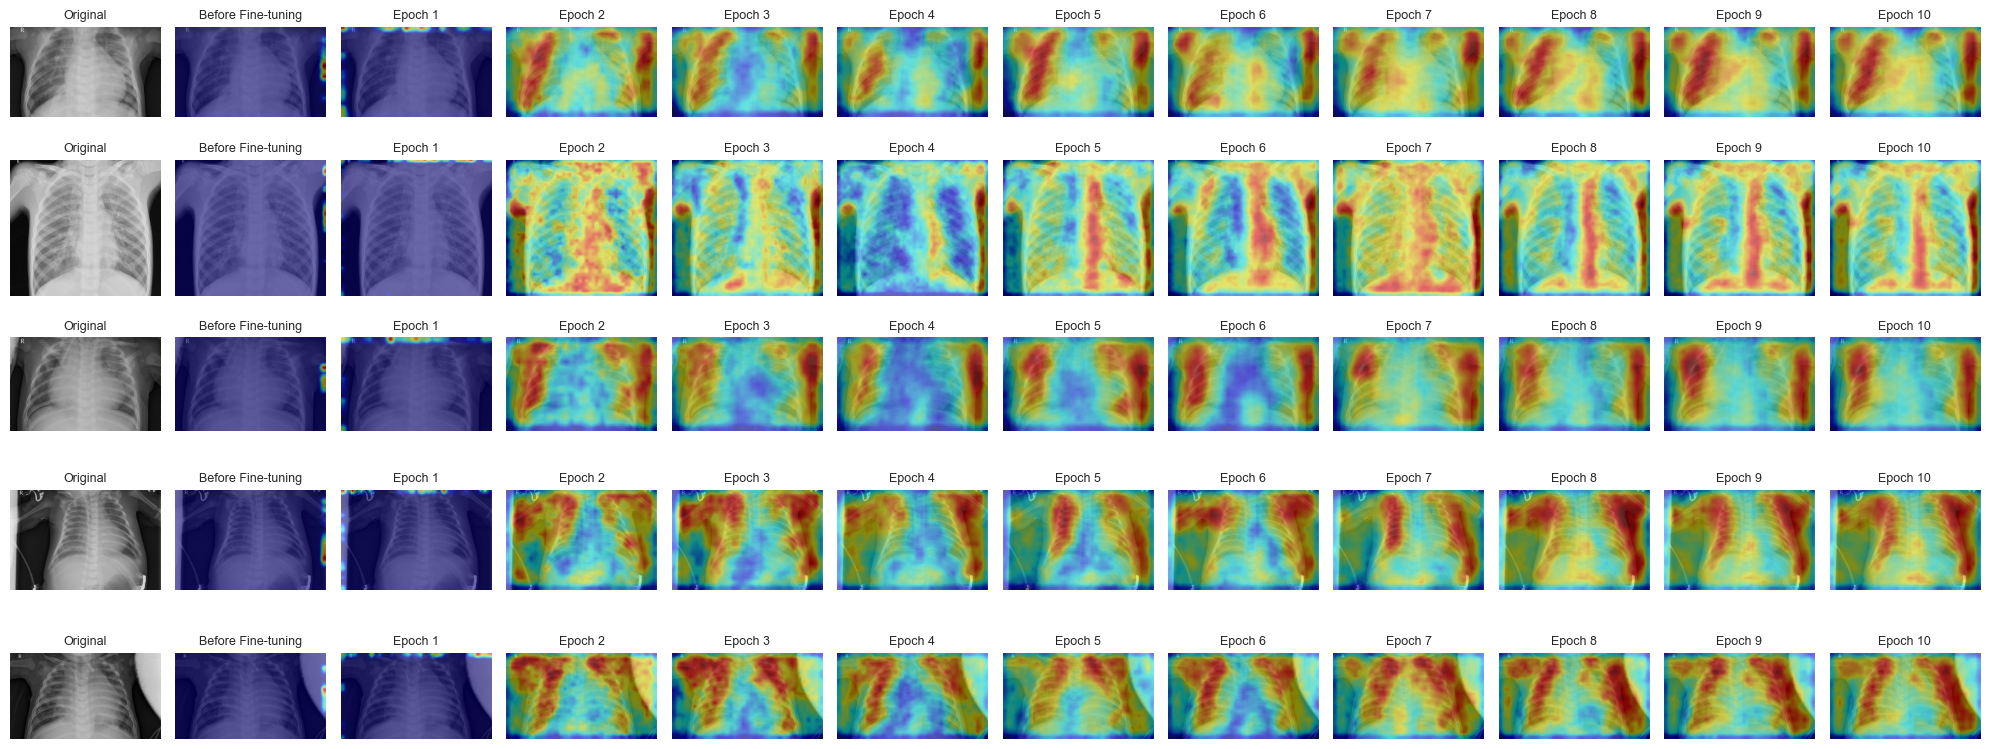

In [11]:
pneumonia_samples = [
    new_test_path + 'PNEUMONIA/person128_bacteria_605.jpeg',
    new_test_path + 'PNEUMONIA/person111_virus_209.jpeg',
    new_test_path + 'PNEUMONIA/person266_bacteria_1249.jpeg',
    new_test_path + 'PNEUMONIA/person297_bacteria_1400.jpeg',
    new_test_path + 'PNEUMONIA/person325_bacteria_1501.jpeg'
]

max_epochs = 10

fig, axs = plt.subplots(len(pneumonia_samples), max_epochs + 2, figsize=(20, 8))
start_index = 0
for row in range(len(pneumonia_samples)):
    filename = Image.open(pneumonia_samples[start_index])
    axs[row, 0].imshow(filename, cmap='gray')
    axs[row, 0].set_title('Original', fontsize=9)
    axs[row, 0].axis('off')
    start_index += 1

    original_filename = filename.filename.split('/')[-1].split('.')[0]

    for col in range(1, max_epochs + 2):
        filename = Image.open(f'D:/6th Sem Projects/CV Project/samples/{original_filename}-cam-epoch-{col-1}.jpeg')
        axs[row, col].imshow(filename, cmap='gray')
        if col == 0:
            title = 'Original'
        if col == 1:
            title = 'Before Fine-tuning'
        if col > 1:
            title = f'Epoch {col - 1}'
        axs[row, col].set_title(title, fontsize=9)
        axs[row, col].axis('off')


plt.tight_layout()
plt.show()

In [27]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=False)  # Assuming you trained your own model
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Modify the output layer according to your task
model.load_state_dict(torch.load('checkpoint-resnet/trained_model.pth', map_location=device))
model.eval()
model = model.to(device)

# Preprocess the input image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device)

# Function to classify chest X-ray image
def classify_image(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        output = model(image)
    probabilities = torch.softmax(output, dim=1)[0]
    pneumonia_probability = probabilities[1].item()
    if pneumonia_probability > 0.5:
        return "Pneumonia Detected", pneumonia_probability
    else:
        return "No Pneumonia Detected", pneumonia_probability

# Example usage:
image_path = 'D:\\6th Sem Projects\\CV Project\\archive_new\\chest_xray\\test\\PNEUMONIA\\person51_virus_105.jpeg'
result, probability = classify_image(image_path)
print("Result:", result)
print("Pneumonia Probability:", probability)


Result: Pneumonia Detected
Pneumonia Probability: 0.9999619722366333
